<a href="https://colab.research.google.com/github/choki0715/UnLiteFlowNet-PIV/blob/master/baseline2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!mkdir data
!unzip /content/drive/MyDrive/beef-quality-prediction/data.zip -d ./data

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: ./data/train/images/cow_1_2821.jpg  
  inflating: ./data/train/images/cow_1_2824.jpg  
  inflating: ./data/train/images/cow_1_2828.jpg  
  inflating: ./data/train/images/cow_1_283.jpg  
  inflating: ./data/train/images/cow_1_2834.jpg  
  inflating: ./data/train/images/cow_1_2835.jpg  
  inflating: ./data/train/images/cow_1_2840.jpg  
  inflating: ./data/train/images/cow_1_2841.jpg  
  inflating: ./data/train/images/cow_1_2843.jpg  
  inflating: ./data/train/images/cow_1_2847.jpg  
  inflating: ./data/train/images/cow_1_285.jpg  
  inflating: ./data/train/images/cow_1_2851.jpg  
  inflating: ./data/train/images/cow_1_2855.jpg  
  inflating: ./data/train/images/cow_1_2858.jpg  
  inflating: ./data/train/images/cow_1_2859.jpg  
  inflating: ./data/train/images/cow_1_286.jpg  
  inflating: ./data/train/images/cow_1_2860.jpg  
  inflating: ./data/train/images/cow_1_2869.jpg  
  inflating: ./data/train/images/cow_1_2871.jpg  
  inflating: ./da

In [ ]:
!pip install timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 431 kB 4.7 MB/s 


In [ ]:
import pandas as pd
import numpy as np
import os
from os import path as osp
import cv2
from tqdm.notebook import tqdm

import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
import albumentations
import timm


import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold

from warnings import filterwarnings
filterwarnings("ignore")

device = torch.device('cuda')

In [ ]:
timm.list_models(pretrained=True)

['adv_inception_v3',
 'bat_resnext26ts',
 'beit_base_patch16_224',
 'beit_base_patch16_224_in22k',
 'beit_base_patch16_384',
 'beit_large_patch16_224',
 'beit_large_patch16_224_in22k',
 'beit_large_patch16_384',
 'beit_large_patch16_512',
 'botnet26t_256',
 'cait_m36_384',
 'cait_m48_448',
 'cait_s24_224',
 'cait_s24_384',
 'cait_s36_384',
 'cait_xs24_384',
 'cait_xxs24_224',
 'cait_xxs24_384',
 'cait_xxs36_224',
 'cait_xxs36_384',
 'coat_lite_mini',
 'coat_lite_small',
 'coat_lite_tiny',
 'coat_mini',
 'coat_tiny',
 'convit_base',
 'convit_small',
 'convit_tiny',
 'convmixer_768_32',
 'convmixer_1024_20_ks9_p14',
 'convmixer_1536_20',
 'convnext_base',
 'convnext_base_384_in22ft1k',
 'convnext_base_in22ft1k',
 'convnext_base_in22k',
 'convnext_large',
 'convnext_large_384_in22ft1k',
 'convnext_large_in22ft1k',
 'convnext_large_in22k',
 'convnext_small',
 'convnext_tiny',
 'convnext_xlarge_384_in22ft1k',
 'convnext_xlarge_in22ft1k',
 'convnext_xlarge_in22k',
 'crossvit_9_240',
 'crossv

In [ ]:
image_size = 224
label_dict = {
    '1++': 0,
    '1+': 1,
    '1': 2,
    '2': 3,
    '3': 4
}
reversed_label_dict = {v:k for k,v in label_dict.items()}

num_classes = len(label_dict)
backbone_name = 'resnest269e'


batch_size = 16
n_worker = 4

init_lr = 2e-5
n_epochs = 200

In [ ]:
train_path = './data/train'
test_path = './data/test'

train_all_df = pd.read_csv(osp.join(train_path, 'grade_labels.csv'))
train_all_df['file_path'] = train_all_df.imname.apply(lambda x: osp.join(train_path, 'images', x))
train_all_df['label'] = train_all_df.grade.apply(lambda x: label_dict[x])

test_df = pd.read_csv(osp.join(test_path, 'test_images.csv'))
test_df['file_path'] = test_df.imname.apply(lambda x: osp.join(test_path, 'images', x))

print(train_all_df.shape)
print(train_all_df.head())
print(test_df.shape)
test_df.head()

(10000, 4)
             imname grade                             file_path  label
0  cow_1++_4567.jpg   1++  ./data/train/images/cow_1++_4567.jpg      0
1    cow_2_1390.jpg     2    ./data/train/images/cow_2_1390.jpg      3
2  cow_1++_2581.jpg   1++  ./data/train/images/cow_1++_2581.jpg      0
3    cow_2_1689.jpg     2    ./data/train/images/cow_2_1689.jpg      3
4    cow_3_3287.jpg     3    ./data/train/images/cow_3_3287.jpg      4
(8658, 2)


,imname,file_path
0,WuSUZJHN6t.jpg,./data/test/images/WuSUZJHN6t.jpg
1,hrua4NW4Cj.jpg,./data/test/images/hrua4NW4Cj.jpg
2,GDOHhHZJug.jpg,./data/test/images/GDOHhHZJug.jpg
3,Xewfe9T1kN.jpg,./data/test/images/Xewfe9T1kN.jpg
4,y3vLHbbHFs.jpg,./data/test/images/y3vLHbbHFs.jpg


In [ ]:
# 이미지의 shape가 (248, 200, 3)이 아닌 이미지가 있는지 확인
for i in range(train_all_df.shape[0]):
  file_path = train_all_df.iloc[i]['file_path']
  image_shape = cv2.imread(file_path).shape
  if image_shape[0] != 248 or image_shape[1] != 200 or image_shape[2] != 3:
    print(file_path, image_shape)
print('done')

done


In [ ]:
train_all_df.grade.unique()

array(['1++', '2', '3', '1+', '1'], dtype=object)

In [ ]:
train_all_df.label.value_counts()

2    2201
0    2134
1    2134
3    2090
4    1441
Name: label, dtype: int64

In [ ]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=139)
train_all_df['fold'] = -1
for fold, (train_idx, valid_idx) in enumerate(skf.split(train_all_df, train_all_df.label)):
    train_all_df.loc[valid_idx, 'fold'] = fold

train_all_df.head()

,imname,grade,file_path,label,fold
0,cow_1++_4567.jpg,1++,./data/train/images/cow_1++_4567.jpg,0,5
1,cow_2_1390.jpg,2,./data/train/images/cow_2_1390.jpg,3,0
2,cow_1++_2581.jpg,1++,./data/train/images/cow_1++_2581.jpg,0,6
3,cow_2_1689.jpg,2,./data/train/images/cow_2_1689.jpg,3,6
4,cow_3_3287.jpg,3,./data/train/images/cow_3_3287.jpg,4,0


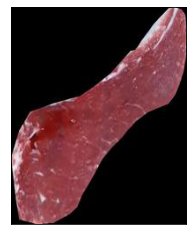

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


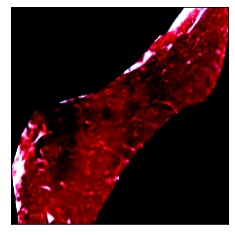

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


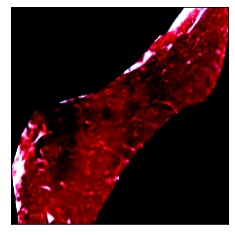

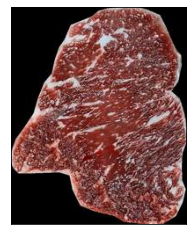

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


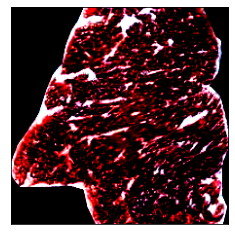

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


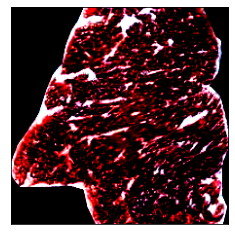

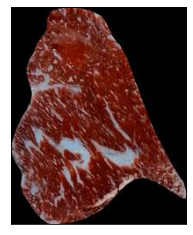

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


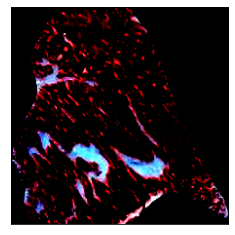

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


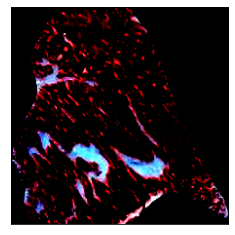

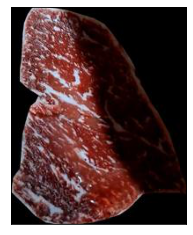

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


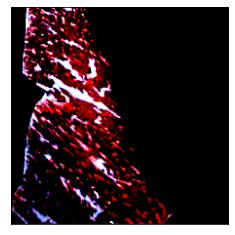

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


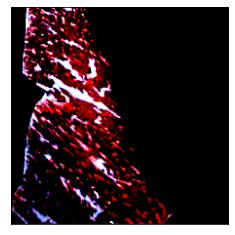

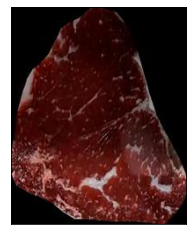

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


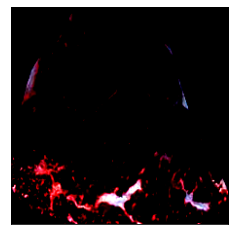

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


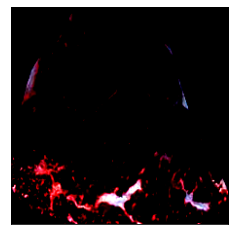

In [ ]:
transform1 = albumentations.Compose([
    albumentations.CenterCrop(200,200),                                 
    albumentations.Resize(image_size, image_size),
    albumentations.Normalize()
])

transform2 = albumentations.Compose([
    albumentations.CenterCrop(200,200),  
    albumentations.Resize(image_size, image_size),
    albumentations.Normalize()
])

for file_path in train_all_df['file_path'].sample(5):
    image = plt.imread(file_path)

    plt.imshow(image)
    plt.xticks([]); plt.yticks([])
    plt.show()

    transformed = transform1(image=image)
    transformed_image = transformed['image']

    plt.imshow(transformed_image)
    plt.xticks([]); plt.yticks([])
    plt.show()

    transformed = transform2(image=image)
    transformed_image = transformed['image']

    plt.imshow(transformed_image)
    plt.xticks([]); plt.yticks([])
    plt.show()

In [ ]:
transforms_train = albumentations.Compose([                                
    albumentations.Resize(image_size, image_size),
    albumentations.HorizontalFlip(p=0.5),
    albumentations.VerticalFlip(p=0.5),
    albumentations.Normalize()
])

transforms_valid = albumentations.Compose([                      
    albumentations.Resize(image_size, image_size),
    albumentations.Normalize()
])

In [ ]:
class BeefDataset(Dataset):
    def __init__(self, df, mode, transform=None):
        self.df = df.reset_index(drop=True)
        self.mode = mode
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        row = self.df.loc[index]
        img = cv2.imread(row.file_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        if self.transform is not None:
            res = self.transform(image=img)
            img = res['image'].transpose(2,0,1)
        
        if self.mode == 'test':
            return torch.tensor(img).float()
        else:
            return torch.tensor(img).float(), torch.tensor(row.label)

In [ ]:
class BeefModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = timm.create_model(backbone_name, pretrained=True, num_classes=num_classes)
    
    def forward(self, x):
        return self.model(x)

In [ ]:
model = BeefModel()
model.to(device);

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-resnest/resnest269-0cc87c48.pth" to /root/.cache/torch/hub/checkpoints/resnest269-0cc87c48.pth


In [ ]:
class LabelSmoothingLoss(nn.Module):
    def __init__(self, classes, smoothing=0.0, dim=-1):
        super(LabelSmoothingLoss, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.cls = classes
        self.dim = dim

    def forward(self, pred, target):
        pred = pred.log_softmax(dim=self.dim)
        with torch.no_grad():
            # true_dist = pred.data.clone()
            true_dist = torch.zeros_like(pred)
            true_dist.fill_(self.smoothing / (self.cls - 1))
            true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        return torch.mean(torch.sum(-true_dist * pred, dim=self.dim))

In [ ]:
optimizer = optim.Adam(model.parameters(), lr = init_lr)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, n_epochs)
criterion = nn.CrossEntropyLoss().to(device)
# criterion = LabelSmoothingLoss(classes=5, smoothing=0.1).to(device)

In [ ]:
fold_id = 0
train_df = train_all_df[train_all_df['fold'] != fold_id]
valid_df = train_all_df[train_all_df['fold'] == fold_id]

dataset_train = BeefDataset(train_df, 'train', transform = transforms_train)
dataset_valid = BeefDataset(valid_df, 'valid', transform = transforms_valid)
dataset_test = BeefDataset(test_df, 'test', transform = transforms_valid)

train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers = n_worker)
valid_loader = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, shuffle=False, num_workers = n_worker)
test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size, shuffle=False, num_workers = n_worker)

In [ ]:
train_df.grade.value_counts()

1      1981
1+     1921
1++    1920
2      1881
3      1297
Name: grade, dtype: int64

In [ ]:
valid_df.grade.value_counts()

1      220
1++    214
1+     213
2      209
3      144
Name: grade, dtype: int64

In [ ]:
def train_epoch(train_loader):
    model.train()
    bar = tqdm(train_loader)
    losses = []
    for batch_idx, (images, targets) in enumerate(bar):

        images, targets = images.to(device), targets.to(device)            
        
        optimizer.zero_grad()

        logit = model(images)
        loss = criterion(logit, targets)
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())

        bar.set_description(f'loss: {loss.item():.5f}')

    loss_train = np.mean(losses)
    return loss_train

def evaluate(valid_loader):
    model.eval() #evaluation 과정에서 사용하지 않아야 하는 layer들을 알아서 off 시키도록 하는 함수
    valid_loss = 0.0
    correct = 0
    with torch.no_grad(): #파라미터 업데이트 안하기 때문에 no_grad 사용
        for images, targets in tqdm(iter(valid_loader)):
            images, targets = images.to(device), targets.to(device)

            logit = model(images)
            valid_loss += criterion(logit, targets)
            pred = logit.argmax(dim=1, keepdim=True)  #11개의 class중 가장 값이 높은 것을 예측 label로 추출
            correct += pred.eq(targets.view_as(pred)).sum().item() #예측값과 실제값이 맞으면 1 아니면 0으로 합산
    valid_acc = 100 * correct / len(valid_loader.dataset)
    print('Valid set: Loss: {:.4f}, Accuracy: {}/{} ( {:.4f}%)\n'.format(valid_loss / len(valid_loader), correct, len(valid_loader.dataset), valid_acc))
    return valid_loss, valid_acc

In [ ]:
best_acc = 0
for epoch in range(1,n_epochs+1):
  train_epoch(train_loader)
  valid_loss, valid_acc = evaluate(valid_loader)

  # 베스트 모델 저장
  if best_acc < valid_acc:
      best_acc = valid_acc
      torch.save(model.state_dict(), f'./{backbone_name}_epoch{epoch}.pth') #이 디렉토리에 best_model.pth을 저장
      print(f'epoch{epoch} Model Saved.')

  0%|          | 0/563 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Valid set: Loss: 1.1570, Accuracy: 491/1000 ( 49.1000%)

epoch1 Model Saved.


  0%|          | 0/563 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Valid set: Loss: 0.9776, Accuracy: 577/1000 ( 57.7000%)

epoch2 Model Saved.


  0%|          | 0/563 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Valid set: Loss: 0.7977, Accuracy: 681/1000 ( 68.1000%)

epoch3 Model Saved.


  0%|          | 0/563 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Valid set: Loss: 0.7117, Accuracy: 730/1000 ( 73.0000%)

epoch4 Model Saved.


  0%|          | 0/563 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Valid set: Loss: 0.6507, Accuracy: 774/1000 ( 77.4000%)

epoch5 Model Saved.


  0%|          | 0/563 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Valid set: Loss: 0.6201, Accuracy: 780/1000 ( 78.0000%)

epoch6 Model Saved.


  0%|          | 0/563 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Valid set: Loss: 0.6376, Accuracy: 791/1000 ( 79.1000%)

epoch7 Model Saved.


  0%|          | 0/563 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Valid set: Loss: 0.5734, Accuracy: 820/1000 ( 82.0000%)

epoch8 Model Saved.


  0%|          | 0/563 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Valid set: Loss: 0.5814, Accuracy: 821/1000 ( 82.1000%)

epoch9 Model Saved.


  0%|          | 0/563 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Valid set: Loss: 0.5613, Accuracy: 823/1000 ( 82.3000%)

epoch10 Model Saved.


  0%|          | 0/563 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Valid set: Loss: 0.5390, Accuracy: 832/1000 ( 83.2000%)

epoch11 Model Saved.


  0%|          | 0/563 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Valid set: Loss: 0.6172, Accuracy: 844/1000 ( 84.4000%)

epoch12 Model Saved.


  0%|          | 0/563 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Valid set: Loss: 0.5255, Accuracy: 865/1000 ( 86.5000%)

epoch13 Model Saved.


  0%|          | 0/563 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Valid set: Loss: 0.6096, Accuracy: 846/1000 ( 84.6000%)



  0%|          | 0/563 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Valid set: Loss: 0.6017, Accuracy: 841/1000 ( 84.1000%)



  0%|          | 0/563 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Valid set: Loss: 0.5627, Accuracy: 831/1000 ( 83.1000%)



  0%|          | 0/563 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Valid set: Loss: 0.5273, Accuracy: 867/1000 ( 86.7000%)

epoch17 Model Saved.


  0%|          | 0/563 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Valid set: Loss: 0.4367, Accuracy: 867/1000 ( 86.7000%)



  0%|          | 0/563 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Valid set: Loss: 0.5075, Accuracy: 863/1000 ( 86.3000%)



  0%|          | 0/563 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Valid set: Loss: 0.5187, Accuracy: 864/1000 ( 86.4000%)



  0%|          | 0/563 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Valid set: Loss: 0.5585, Accuracy: 855/1000 ( 85.5000%)



  0%|          | 0/563 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Valid set: Loss: 0.4808, Accuracy: 874/1000 ( 87.4000%)

epoch22 Model Saved.


  0%|          | 0/563 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Valid set: Loss: 0.5449, Accuracy: 865/1000 ( 86.5000%)



  0%|          | 0/563 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Valid set: Loss: 0.4925, Accuracy: 879/1000 ( 87.9000%)

epoch24 Model Saved.


  0%|          | 0/563 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Valid set: Loss: 0.5513, Accuracy: 862/1000 ( 86.2000%)



  0%|          | 0/563 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Valid set: Loss: 0.5622, Accuracy: 865/1000 ( 86.5000%)



  0%|          | 0/563 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Valid set: Loss: 0.5879, Accuracy: 854/1000 ( 85.4000%)



  0%|          | 0/563 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Valid set: Loss: 0.6236, Accuracy: 853/1000 ( 85.3000%)



  0%|          | 0/563 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Valid set: Loss: 0.6312, Accuracy: 845/1000 ( 84.5000%)



  0%|          | 0/563 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Valid set: Loss: 0.6336, Accuracy: 862/1000 ( 86.2000%)



  0%|          | 0/563 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Valid set: Loss: 0.5205, Accuracy: 863/1000 ( 86.3000%)



  0%|          | 0/563 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Valid set: Loss: 0.5550, Accuracy: 861/1000 ( 86.1000%)



  0%|          | 0/563 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Valid set: Loss: 0.5166, Accuracy: 871/1000 ( 87.1000%)



  0%|          | 0/563 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Valid set: Loss: 0.4719, Accuracy: 865/1000 ( 86.5000%)



  0%|          | 0/563 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Valid set: Loss: 0.5268, Accuracy: 881/1000 ( 88.1000%)

epoch35 Model Saved.


  0%|          | 0/563 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Valid set: Loss: 0.5312, Accuracy: 862/1000 ( 86.2000%)



  0%|          | 0/563 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Valid set: Loss: 0.5040, Accuracy: 876/1000 ( 87.6000%)



  0%|          | 0/563 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Valid set: Loss: 0.5162, Accuracy: 885/1000 ( 88.5000%)

epoch38 Model Saved.


  0%|          | 0/563 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Valid set: Loss: 0.4957, Accuracy: 885/1000 ( 88.5000%)



  0%|          | 0/563 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Valid set: Loss: 0.5707, Accuracy: 875/1000 ( 87.5000%)



  0%|          | 0/563 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Valid set: Loss: 0.4806, Accuracy: 880/1000 ( 88.0000%)



  0%|          | 0/563 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Valid set: Loss: 0.6210, Accuracy: 853/1000 ( 85.3000%)



  0%|          | 0/563 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Valid set: Loss: 0.5267, Accuracy: 866/1000 ( 86.6000%)



  0%|          | 0/563 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Valid set: Loss: 0.4482, Accuracy: 893/1000 ( 89.3000%)

epoch44 Model Saved.


  0%|          | 0/563 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Valid set: Loss: 0.5551, Accuracy: 877/1000 ( 87.7000%)



  0%|          | 0/563 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Valid set: Loss: 0.5582, Accuracy: 877/1000 ( 87.7000%)



  0%|          | 0/563 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Valid set: Loss: 0.4986, Accuracy: 877/1000 ( 87.7000%)



  0%|          | 0/563 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Valid set: Loss: 0.4646, Accuracy: 889/1000 ( 88.9000%)



  0%|          | 0/563 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Valid set: Loss: 0.4818, Accuracy: 888/1000 ( 88.8000%)



  0%|          | 0/563 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Valid set: Loss: 0.6871, Accuracy: 853/1000 ( 85.3000%)



  0%|          | 0/563 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Valid set: Loss: 0.5298, Accuracy: 872/1000 ( 87.2000%)



  0%|          | 0/563 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Valid set: Loss: 0.5373, Accuracy: 875/1000 ( 87.5000%)



  0%|          | 0/563 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Valid set: Loss: 0.4570, Accuracy: 892/1000 ( 89.2000%)



  0%|          | 0/563 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Valid set: Loss: 0.5155, Accuracy: 876/1000 ( 87.6000%)



  0%|          | 0/563 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Valid set: Loss: 0.4728, Accuracy: 890/1000 ( 89.0000%)



  0%|          | 0/563 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Valid set: Loss: 0.4124, Accuracy: 902/1000 ( 90.2000%)

epoch56 Model Saved.


  0%|          | 0/563 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Valid set: Loss: 0.5155, Accuracy: 883/1000 ( 88.3000%)



  0%|          | 0/563 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Valid set: Loss: 0.4899, Accuracy: 893/1000 ( 89.3000%)



  0%|          | 0/563 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Valid set: Loss: 0.4912, Accuracy: 892/1000 ( 89.2000%)



  0%|          | 0/563 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Valid set: Loss: 0.5090, Accuracy: 880/1000 ( 88.0000%)



  0%|          | 0/563 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Valid set: Loss: 0.5298, Accuracy: 870/1000 ( 87.0000%)



  0%|          | 0/563 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Valid set: Loss: 0.4276, Accuracy: 902/1000 ( 90.2000%)



  0%|          | 0/563 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Valid set: Loss: 0.4545, Accuracy: 894/1000 ( 89.4000%)



  0%|          | 0/563 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Valid set: Loss: 0.5273, Accuracy: 892/1000 ( 89.2000%)



  0%|          | 0/563 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Valid set: Loss: 0.4515, Accuracy: 880/1000 ( 88.0000%)



  0%|          | 0/563 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Valid set: Loss: 0.4865, Accuracy: 872/1000 ( 87.2000%)



  0%|          | 0/563 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Valid set: Loss: 0.4383, Accuracy: 889/1000 ( 88.9000%)



  0%|          | 0/563 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Valid set: Loss: 0.4357, Accuracy: 898/1000 ( 89.8000%)



  0%|          | 0/563 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Valid set: Loss: 0.4514, Accuracy: 896/1000 ( 89.6000%)



  0%|          | 0/563 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Valid set: Loss: 0.4334, Accuracy: 899/1000 ( 89.9000%)



  0%|          | 0/563 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Valid set: Loss: 0.5125, Accuracy: 881/1000 ( 88.1000%)



  0%|          | 0/563 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Valid set: Loss: 0.4497, Accuracy: 898/1000 ( 89.8000%)



  0%|          | 0/563 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Valid set: Loss: 0.4788, Accuracy: 894/1000 ( 89.4000%)



  0%|          | 0/563 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Valid set: Loss: 0.5240, Accuracy: 880/1000 ( 88.0000%)



  0%|          | 0/563 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Valid set: Loss: 0.5317, Accuracy: 893/1000 ( 89.3000%)



  0%|          | 0/563 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Valid set: Loss: 0.5588, Accuracy: 869/1000 ( 86.9000%)



  0%|          | 0/563 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Valid set: Loss: 0.4589, Accuracy: 896/1000 ( 89.6000%)



  0%|          | 0/563 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Valid set: Loss: 0.4720, Accuracy: 895/1000 ( 89.5000%)



  0%|          | 0/563 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Valid set: Loss: 0.4465, Accuracy: 910/1000 ( 91.0000%)

epoch79 Model Saved.


  0%|          | 0/563 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Valid set: Loss: 0.4816, Accuracy: 895/1000 ( 89.5000%)



  0%|          | 0/563 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Valid set: Loss: 0.4266, Accuracy: 887/1000 ( 88.7000%)



  0%|          | 0/563 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
model.load_state_dict(torch.load('/content/resnest269e_epoch79.pth'))
evaluate(valid_loader)

  0%|          | 0/63 [00:00<?, ?it/s]

Valid set: Loss: 0.4465, Accuracy: 910/1000 ( 91.0000%)



(tensor(28.1320, device='cuda:0'), 91.0)

In [ ]:
# test code

preds = []

model.eval()
with torch.no_grad(): #파라미터 업데이트 안하기 때문에 no_grad 사용
    for images in tqdm(iter(test_loader)):
        images = images.to(device)

        logit = model(images)
        pred = logit.argmax(dim=1)  #11개의 class중 가장 값이 높은 것을 예측 label로 추출
        # print(pred.tolist())
        preds.extend(pred.tolist())

  0%|          | 0/542 [00:00<?, ?it/s]

In [ ]:
grade_preds = [reversed_label_dict[pred] for pred in preds]

submission = pd.read_csv('./data/sample_submission.csv')
temp = submission.copy()
temp['id'] = test_df.imname
temp['grade'] = grade_preds

submission = pd.merge(submission['id'], temp, on='id', how='left')
submission.to_csv('submit.csv', index=False)